# FEATURE ENGINEERING WITH PYSPARK
## important aspect of machine learning
### before diving to analysis
    -- Become your own expert 
    -- define your goals for analysis and how the output might be used
    -- research data 
    -- be curious
### data science project
#### Project Scoping / Data collection -> Exploratory ANalysis -> Data cleaning -> Feature Engineering -> model treining -> Project delivery / insights

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("feature_eng").getOrCreate()

In [3]:
import sys
print("spark version: ", spark.version)
print("python version: ", sys.version_info)

spark version:  3.5.4
python version:  sys.version_info(major=3, minor=10, micro=18, releaselevel='final', serial=0)


# advantage of parquet data format
   - ## Stored Column-wise
        - ### Fast to query column subsets
   - ## Structured, defined schema
        - ### Fields and data types defined
        - ### Great for messy text data
   - ## industry adopted

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dschettler8845/recsys-2020-ecommerce-dataset")

print("Path to dataset files:", path)

C:\Users\kizer\miniconda3\envs\spark354_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 629M/629M [00:42<00:00, 15.5MB/s] 

Extracting model files...


Path to dataset files: C:\Users\kizer\.cache\kagglehub\datasets\dschettler8845\recsys-2020-ecommerce-dataset\versions\1


In [3]:
whole_path_test = "C:\\Users\\kizer\\.cache\\kagglehub\\datasets\\dschettler8845\\recsys-2020-ecommerce-dataset\\versions\\1\\test.parquet"
whole_path_train = "C:\\Users\\kizer\\.cache\\kagglehub\\datasets\\dschettler8845\\recsys-2020-ecommerce-dataset\\versions\\1\\train.parquet"

In [4]:
df = spark.read.parquet(whole_path_train)
df.show()

+--------------------+----------+----------+-------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|          event_time|event_type|product_id|  brand|  price|  user_id|        user_session|target|      cat_0|     cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+--------------------+----------+----------+-------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|2019-11-01 00:00:...|      cart|   1005014|samsung| 503.09|533326659|6b928be2-2bce-464...|     0|electronics|smartphone|       NA|   NA|2019-11-01 01:00:14|      0|        0|         4|     1|      11|   2019|
|2019-11-01 00:03:...|      cart|   1005115|  apple| 949.47|565865924|fd4bd6d4-bd14-4fd...|     0|electronics|smartphone|       NA|   NA|2019-11-01 01:03:39

In [5]:
df.describe()

DataFrame[summary: string, event_time: string, event_type: string, product_id: string, brand: string, price: string, user_id: string, user_session: string, target: string, cat_0: string, cat_1: string, cat_2: string, cat_3: string, ts_hour: string, ts_minute: string, ts_weekday: string, ts_day: string, ts_month: string, ts_year: string]

In [6]:
from pyspark.sql.types import DateType, IntegerType, DoubleType
from pyspark.sql.functions import to_timestamp
df_casted = df.withColumn("price_int", df["price"].cast(DoubleType())).withColumn("ts_month_int", df["ts_month"].cast(IntegerType())).withColumn("ts_year_int", df["ts_year"].cast(IntegerType())).withColumn("ts_day_int", df["ts_day"].cast(IntegerType())).withColumn("ts_weekday_int", df["ts_weekday"].cast(IntegerType()))
columns_to_drop = ['ts_month', 'price', 'ts_year', 'ts_day', 'ts_weekday']
df_casted = df_casted.drop(*columns_to_drop)
#df_casted = df_casted.withColumn("event_time_corr", to_timestamp(df["event_time"], "yyyy-MM-dd HH:mm:ss"))
df_casted.show()

+--------------------+----------+----------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+---------+------------+-----------+----------+--------------+
|          event_time|event_type|product_id|  brand|  user_id|        user_session|target|      cat_0|     cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|price_int|ts_month_int|ts_year_int|ts_day_int|ts_weekday_int|
+--------------------+----------+----------+-------+---------+--------------------+------+-----------+----------+---------+-----+-------------------+-------+---------+---------+------------+-----------+----------+--------------+
|2019-11-01 00:00:...|      cart|   1005014|samsung|533326659|6b928be2-2bce-464...|     0|electronics|smartphone|       NA|   NA|2019-11-01 01:00:14|      0|        0|   503.09|          11|       2019|         1|             4|
|2019-11-01 00:03:...|      cart|   1005115|  apple|565865924|fd4bd6d4-bd14-4fd...| 

In [7]:
df_casted.describe(['price_int']).show()

+-------+-----------------+
|summary|        price_int|
+-------+-----------------+
|  count|         11495242|
|   mean|287.9644098358388|
| stddev|331.5377135506471|
|    min|              0.0|
|    max|          2574.07|
+-------+-----------------+



In [8]:
df_casted.agg({'price_int': 'mean'}).collect()

[Row(avg(price_int)=287.9644098358388)]

In [9]:
df_casted.cov('price_int', 'ts_month_int')

-14.229403072645727

In [10]:
df_casted.count()

11495242

In [11]:
df_casted.sample(False, 0.5, 42).count()

5747189

C:\Users\kizer\AppData\Local\Temp\ipykernel_23580\1783027884.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df)


<Axes: ylabel='Density'>

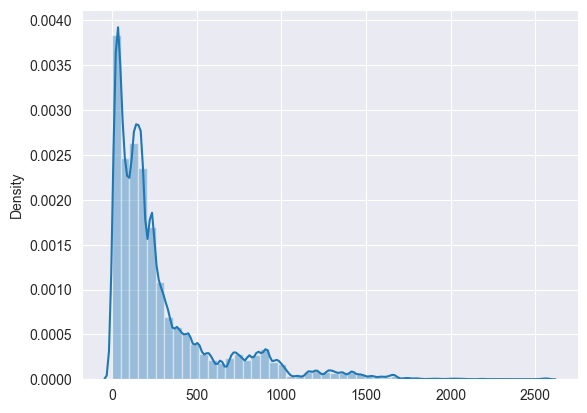

In [12]:
import seaborn as sns

sample_df = df_casted.select('price_int').sample(False, 0.5, 42)

pandas_df = sample_df.toPandas()
sns.distplot(pandas_df)

In [13]:
s_df = df_casted.select(['price_int', 'ts_weekday_int'])
s_df = s_df.sample(False, 0.1, 42)
pandas_df_s = s_df.toPandas()

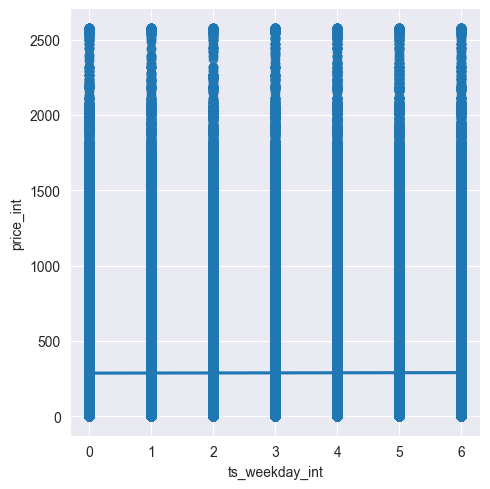

In [14]:
sns.lmplot(x='ts_weekday_int', y='price_int', data=pandas_df_s)

In [15]:
#value filtering data using 3 std distance
std_val = df_casted.agg({'price_int': 'stddev'}).collect()[0][0]
mean_val = df_casted.agg({'price_int': 'mean'}).collect()[0][0]

hi_bound = mean_val+(3*std_val)
low_bound = mean_val-(3*std_val)

df_filtered = df_casted.where((df_casted['price_int'] < hi_bound) & (df_casted['price_int'] > low_bound))
num_rows = df_filtered.count()
print(df_casted.count())
print(num_rows)
#df_filtered.show()

11495242
11203806


In [16]:
df.dropna(how='any', tresh=50, subset=['ts_weekday_int']) #if in how 'any' than drop a record if it contains any nulls.
# If 'all' drop a record only if all its values are null
#thresh: int, if specified drop records that have less than tresh non-null values, overwrites the how parameter
#subset: optional list of column names to consider

TypeError: DataFrame.dropna() got an unexpected keyword argument 'tresh'

In [20]:
# MinMax scaling
# we take variable to be scaled, substract by minimum value and divide by substaction of max and min value
# Xi,j* = (Xi,j - Xj MIN) / (Xj MAX - Xj MIN) 

max_price = df_casted.agg({'price_int': 'max'}).collect()[0][0]
min_price = df_casted.agg({'price_int': 'min'}).collect()[0][0]

df_casted = df_casted.withColumn("scaled_price",
                                 (df_casted['price_int'] - min_price) / (max_price - min_price))
df_casted[['scaled_price']].show(5)

+-------------------+
|       scaled_price|
+-------------------+
| 0.1954453453091796|
| 0.3688594327271597|
| 0.1891168460842168|
| 0.1891168460842168|
|0.06237981096085187|
+-------------------+
only showing top 5 rows



In [22]:
# Standardization - transforming data to standard normal distribution, mean = 0 and std = 1
df_casted = df_casted.withColumn("ztrans_price",
                                 (df_casted['price_int'] - mean_val) / std_val)
df_casted.agg({'ztrans_price': 'mean'}).collect()

[Row(avg(ztrans_price)=-2.4421258171688696e-14)]

In [23]:
df_casted.agg({'ztrans_price': 'stddev'}).collect()

[Row(stddev(ztrans_price)=0.9999999999999991)]

<Axes: ylabel='Count'>

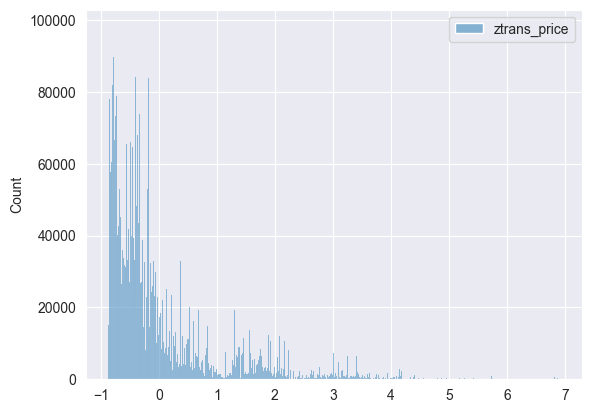

In [25]:
sam_df = df_casted.select('ztrans_price').sample(False, 0.5, 42)

pan_df = sam_df.toPandas()
sns.histplot(pan_df)

<Axes: ylabel='Count'>

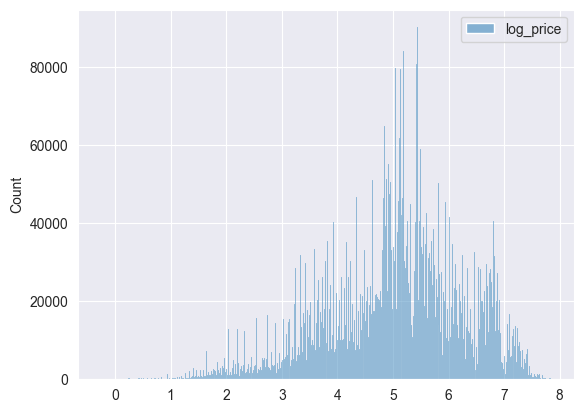

In [26]:
#log scaling
from pyspark.sql.functions import log

df_casted = df_casted.withColumn('log_price', log(df_casted['price_int']))

sa_df = df_casted.select('log_price').sample(False, 0.5, 42)

pa_df = sa_df.toPandas()
sns.histplot(pa_df)